In [1]:
# Libraries

import os
from time import time
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.optim import Adam
import torch.nn as nn
from torch.nn import CrossEntropyLoss, Conv2d, AvgPool2d, BatchNorm2d, Dropout2d, LeakyReLU, Linear, Module
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F

from torchvision.datasets import ImageFolder
from torchvision.models import resnet50
from torchvision.transforms import transforms


# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## data load and data transformation

In [2]:
# Data Transformer
transform = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

In [3]:
# Create Dataset
train_dir = '/Users/khadygaye/Downloads/Eye_diseases/train' 
test_dir  = "/Users/khadygaye/Downloads/Eye_diseases/test"

train_ds = ImageFolder(train_dir, transform=transform)
test_ds = ImageFolder(test_dir, transform=transform)
#print(train_ds)

In [4]:
img , label = train_ds[9]
img.shape


torch.Size([3, 250, 250])

In [5]:
# Index Mapping
class_name = train_ds.class_to_idx
print(train_ds.class_to_idx)

{'Bulging_Eyes': 0, 'Cataracts': 1, 'Crossed_Eyes': 2, 'Glaucoma': 3, 'Uveitis': 4}


We can see that our dataset contains 5 type of disease  

In [29]:
batch_size = 64

print(f"Length of Validation Data : {len(train_ds)}")
print(f"length of  text data : {len(test_ds)}")

#load the train and validation into batches.
train_loader = DataLoader(train_ds, batch_size, shuffle = True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle = True)

Length of Validation Data : 879
length of  text data : 383


## Visualisation of the disease 

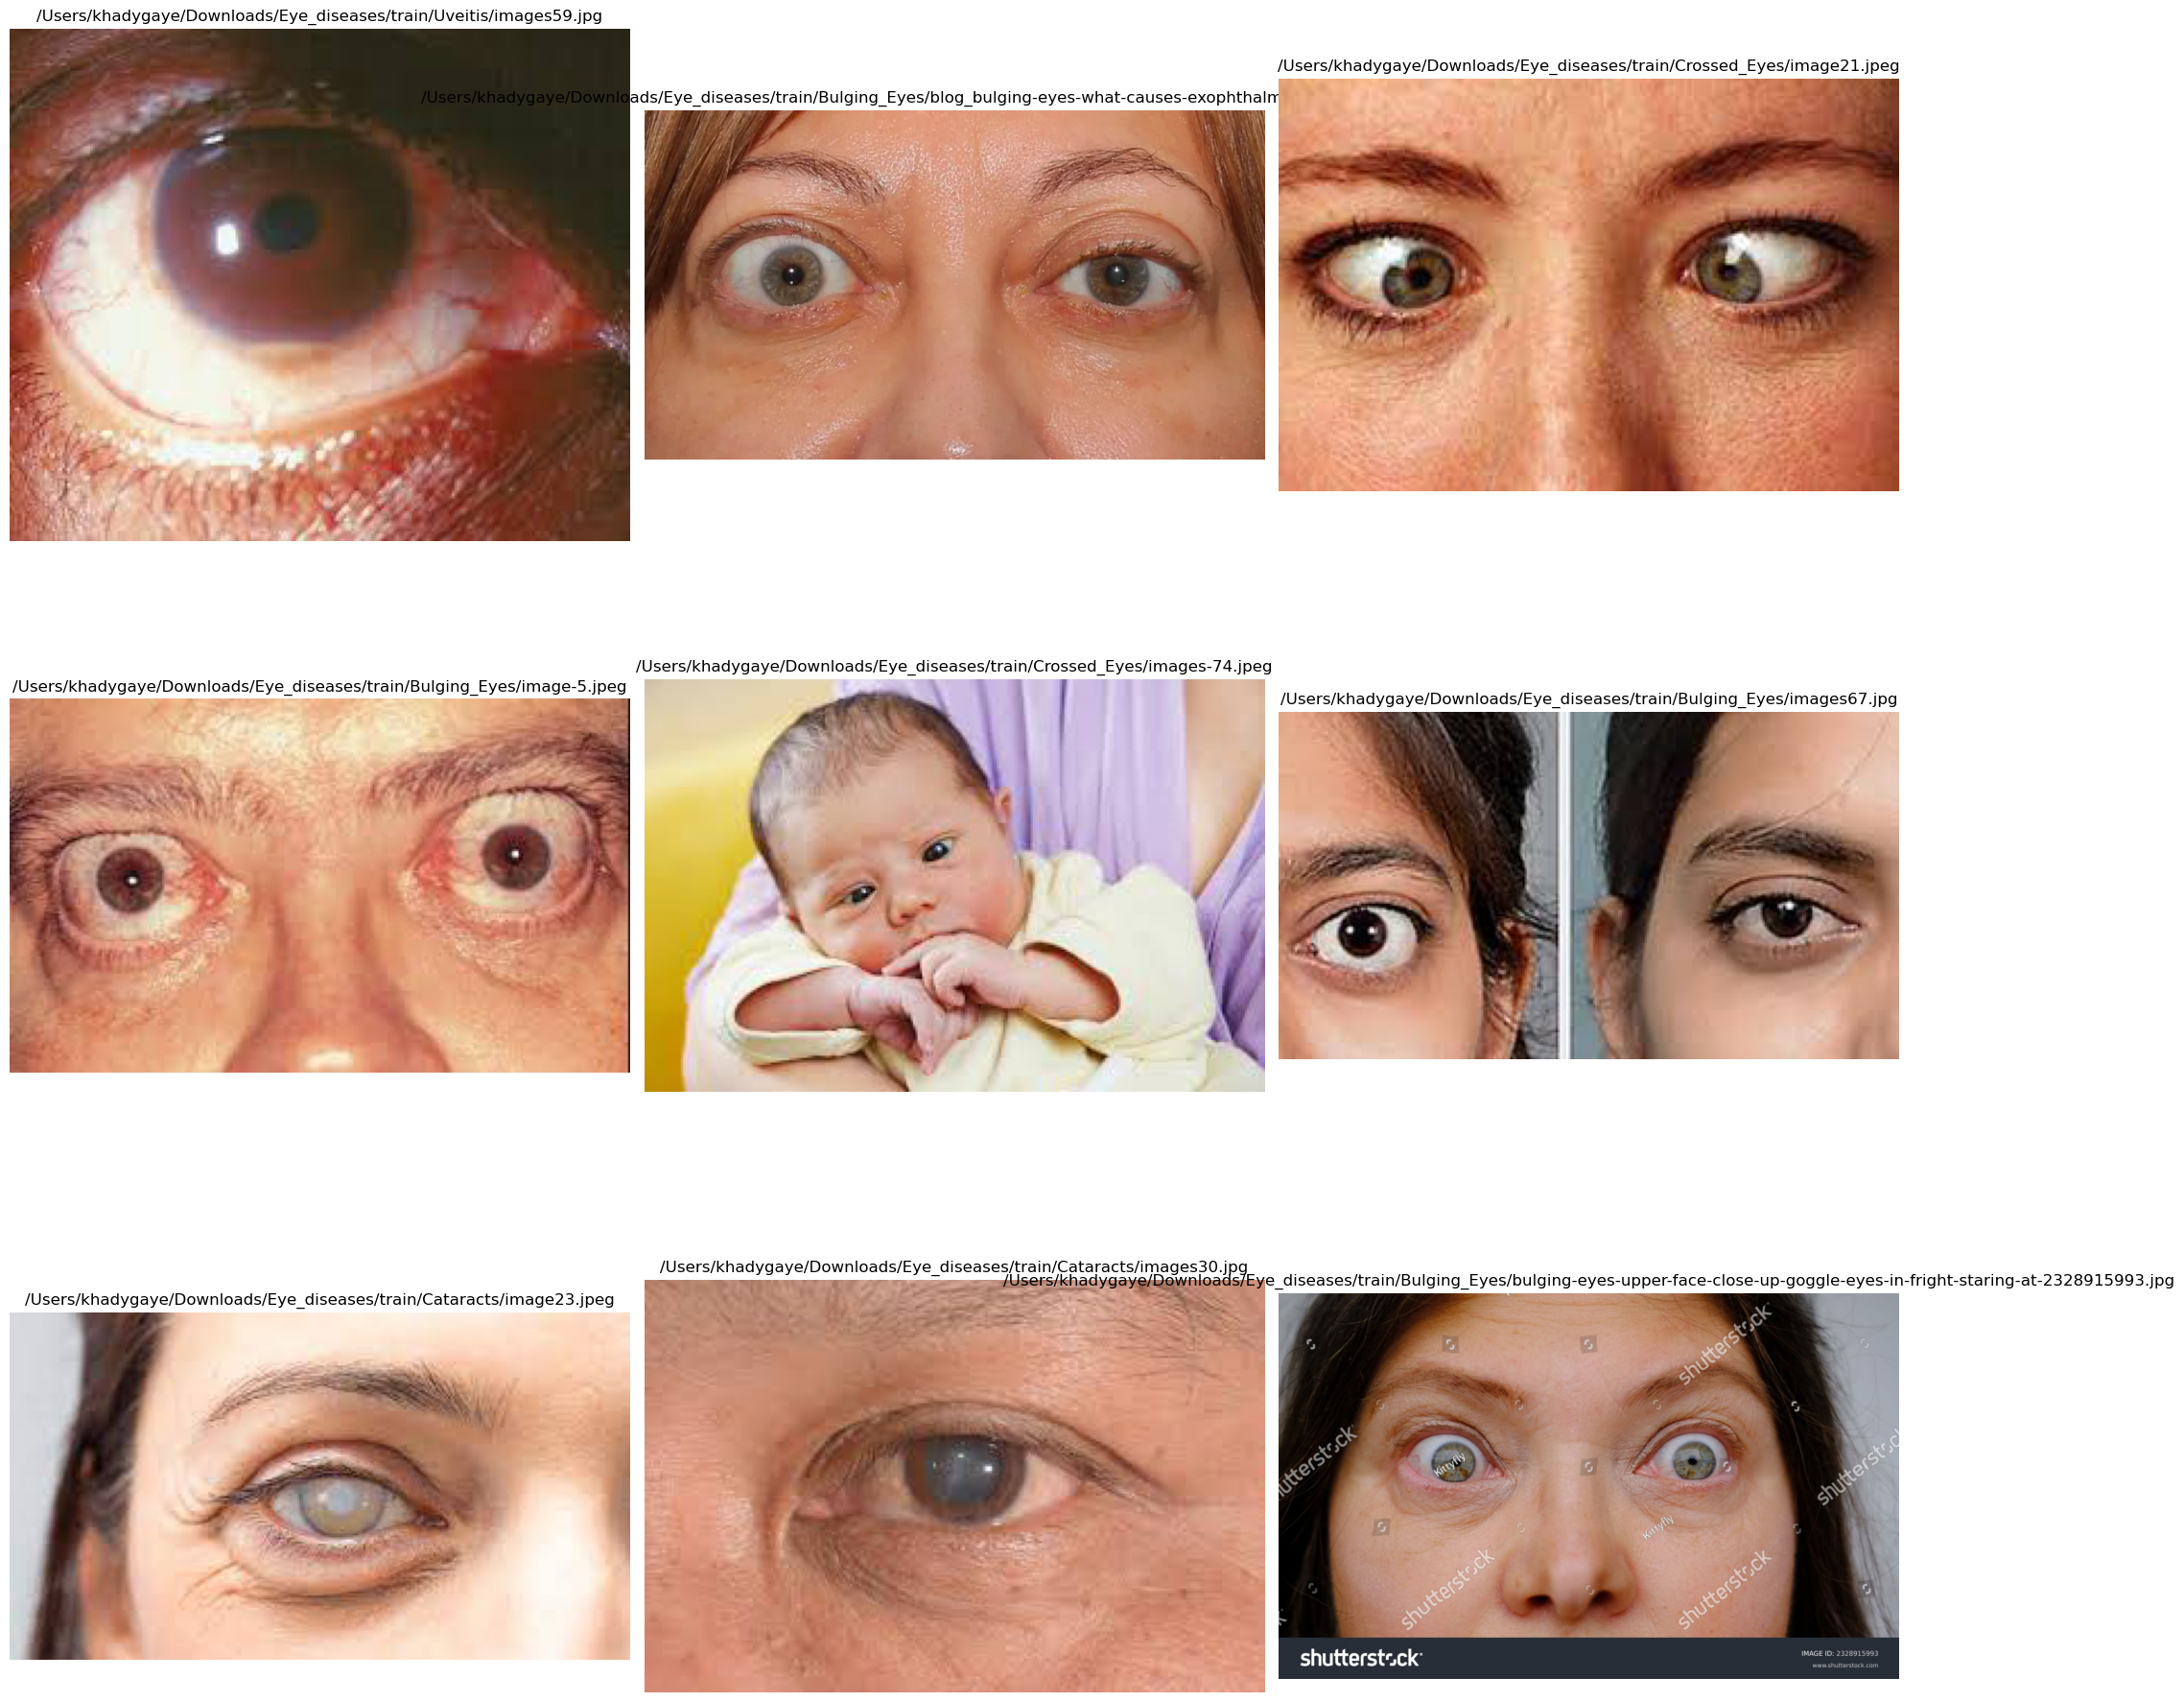

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
train_dir = '/Users/khadygaye/Downloads/Eye_diseases/train/' 
path = []
for dirname, _, filenames in os.walk(train_dir):
    for filename in filenames:
        image = os.path.join(dirname, filename)
        path.append(image)

path_choose = [np.random.choice(path) for i in range(9)]

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(path_choose[i])
    plt.imshow(img, cmap='gray')
    plt.title(path_choose[i])
    #plt.title(train_df['labels'][i])
    plt.axis('off')
 
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()    



## Build Model, Optimiser and Loss Function

### Convolutional Neural Network Model

In [8]:
class CNN_EYE_DISEASE(nn.Module):
    def __init__(self, input_channels, output_classes, dropout_prob):
        super(CNN_EYE_DISEASE, self).__init__()
        self.input_channels = input_channels
        self.output_classes = output_classes
        self.dropout_prob = dropout_prob

        self.activation = nn.ReLU(inplace=True)
        self.pool = nn.AvgPool2d(kernel_size=3, stride=1)
        
        self.conv1 = nn.Conv2d(in_channels=self.input_channels, out_channels=250, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=250)
        self.conv2 = nn.Conv2d(in_channels=250, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        
        self.fc1 = nn.Linear(in_features=64 * 246 * 246, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=self.output_classes)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, X):
        # Convolution Layer 1
        output = self.conv1(X)
        output = self.pool(output)
        output = self.bn1(output)
        output = self.activation(output)
        # Convolution Layer 2
        output = self.conv2(output)
        output = self.pool(output)
        output = self.bn2(output)
        output = self.activation(output)
        # Flatten Output
        output = output.view(output.size(0), -1)  
        # Fully Connected Layers
        output = self.fc1(output)
        output = self.activation(output)
        output = self.fc2(output)
        output = self.softmax(output)
        return output
    

In [9]:
# Instantiate the Model    
input_channels = 3
output_classes = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_EYE_DISEASE(input_channels=input_channels, output_classes=output_classes)
model = model.to(device)



## Resnet Model

In [10]:
# Model
resnet = resnet50(pretrained=True)
resnet.fc = Linear(in_features=2048, out_features=5)
resnet = resnet.to(device)

/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Train and Evaluate the Model

In [12]:
def train(model, train_loader, optimizer, device, loss_fn):
    model.train()
    train_acc = 0
    
    for xtrain, ytrain in tqdm(train_loader, unit="batch"):
        optimizer.zero_grad()
        
        xtrain = xtrain.to(device)
        ytrain = ytrain.to(device)
        
        train_prob = model(xtrain)
        loss = loss_fn(train_prob, ytrain) 
        loss.backward()
        optimizer.step()
        
        train_pred = torch.max(train_prob, 1).indices
        train_acc += int(torch.sum(train_pred == ytrain))
        
    return train_acc / len(train_loader.dataset) , loss

In [13]:
def test(model, test_loader, device):
    model.eval()
    test_acc = 0
    with torch.no_grad():
        for xtest, ytest in test_loader:
            xtest = xtest.to(device)
            test_prob = model(xtest)
            test_prob = test_prob.cpu()
            
            test_pred = torch.max(test_prob,1).indices
            test_acc += int(torch.sum(test_pred == ytest))
    

            
    return test_acc / len(test_loader.dataset)


In [18]:

input_channels = 3
output_classes = 5
dropout_prob = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_EYE_DISEASE(input_channels=input_channels, output_classes=output_classes)#, dropout_prob=dropout_prob)
model = model.to(device)
optimiser = Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)
loss_fn = nn.NLLLoss()

In [19]:


# Training loop
train_acc_list = []
test_acc_list = []

for epoch in range(10):
    start = time()

    train_acc , loss = train(model, train_loader, optimizer, device, loss_fn)
    test_acc = test(model, test_loader, device)
    
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    
    end = time()
    duration = (end - start) / 60
    
    print(f"Epoch: {epoch}, Time: {duration} min,  Loss:{loss},  Train Acc: {train_acc}, Test Acc: {test_acc}")


100%|██████████| 10/10 [15:45<00:00, 94.58s/batch]


Epoch: 0, Time: 16.658714433511097 min,  Loss:227.08010864257812,  Train Acc: 0.24960254372019078, Test Acc: 0.46475195822454307


100%|██████████| 10/10 [32:02<00:00, 192.27s/batch] 


Epoch: 1, Time: 33.00014137824376 min,  Loss:44.56209945678711,  Train Acc: 0.31160572337042924, Test Acc: 0.4308093994778068


100%|██████████| 10/10 [08:05<00:00, 48.51s/batch]


Epoch: 2, Time: 8.98298933506012 min,  Loss:25.894771575927734,  Train Acc: 0.40381558028616854, Test Acc: 0.2010443864229765


100%|██████████| 10/10 [08:13<00:00, 49.31s/batch]


Epoch: 3, Time: 9.199751083056132 min,  Loss:9.04990005493164,  Train Acc: 0.3624801271860095, Test Acc: 0.35509138381201044


100%|██████████| 10/10 [08:08<00:00, 48.82s/batch]


Epoch: 4, Time: 9.07831918001175 min,  Loss:14.001410484313965,  Train Acc: 0.4117647058823529, Test Acc: 0.39947780678851175


100%|██████████| 10/10 [07:54<00:00, 47.43s/batch]


Epoch: 5, Time: 8.833587233225504 min,  Loss:9.52869701385498,  Train Acc: 0.43720190779014306, Test Acc: 0.4595300261096606


100%|██████████| 10/10 [07:51<00:00, 47.11s/batch]


Epoch: 6, Time: 8.770222496986388 min,  Loss:5.704766750335693,  Train Acc: 0.5389507154213037, Test Acc: 0.370757180156658


100%|██████████| 10/10 [08:10<00:00, 49.04s/batch]


Epoch: 7, Time: 9.091852100690206 min,  Loss:5.3910441398620605,  Train Acc: 0.505564387917329, Test Acc: 0.2898172323759791


100%|██████████| 10/10 [08:00<00:00, 48.09s/batch]


Epoch: 8, Time: 8.972160279750824 min,  Loss:10.167129516601562,  Train Acc: 0.5023847376788553, Test Acc: 0.4830287206266319


100%|██████████| 10/10 [07:52<00:00, 47.27s/batch]


Epoch: 9, Time: 8.798170749346415 min,  Loss:2.292584180831909,  Train Acc: 0.32591414944356123, Test Acc: 0.23759791122715404


In [20]:
print(train_acc_list)
print(test_acc_list)

[0.24960254372019078, 0.31160572337042924, 0.40381558028616854, 0.3624801271860095, 0.4117647058823529, 0.43720190779014306, 0.5389507154213037, 0.505564387917329, 0.5023847376788553, 0.32591414944356123]
[0.46475195822454307, 0.4308093994778068, 0.2010443864229765, 0.35509138381201044, 0.39947780678851175, 0.4595300261096606, 0.370757180156658, 0.2898172323759791, 0.4830287206266319, 0.23759791122715404]


## Model Performance on Samples

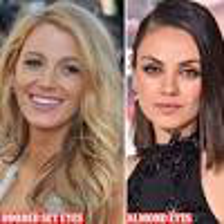

Model prediction 3, Glaucoma


In [21]:
from PIL import Image
import numpy as np
saple = '/Users/khadygaye/Downloads/Eye_diseases/train/Bulging_Eyes/images66.jpg'
img = Image.open(saple)
display(img.resize((224,224)))
img_tensor = transform(img)
img_tensor = img_tensor[np.newaxis, :]
img_tensor = img_tensor.to(device)
pred_prob = model(img_tensor)
pred = torch.max(pred_prob,1).indices
pred = pred.item()


if pred == 0:
    print(f"Model prediction {pred}, Bulging_Eyes")
elif pred ==1 :
    print(f"Model prediction {pred}, Cataracts")
elif pred ==2 :
    print(f"Model prediction {pred}, Crossed_Eyes")
elif pred ==3 :
    print(f"Model prediction {pred}, Glaucoma")
else:
    print(f"Model prediction {pred}, Uveitis")



print("========================================================")

### Plot text accurency and train accurency

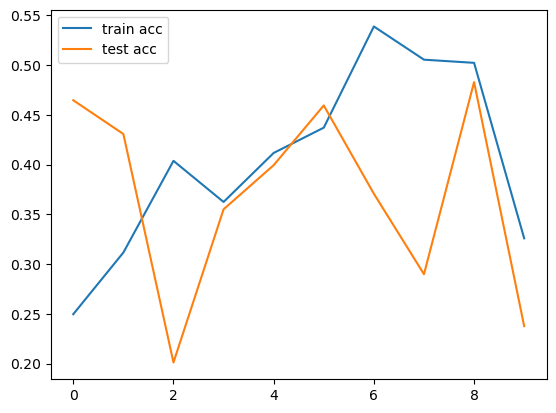

In [22]:
# Loss
import matplotlib.pyplot as plt
Epoch = 10
plt.plot(range(Epoch),train_acc_list, label="train acc")

plt.plot(range(Epoch),test_acc_list, label="test acc")
plt.legend()

## text for Resnet models 

In [25]:
# model 
model = resnet
optimiser = Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)
# Loss Function
loss_fn = CrossEntropyLoss()

In [26]:


# Training loop
train_acc_list = []
test_acc_list = []

for epoch in range(10):
    start = time()

    train_acc , loss = train(model, train_loader, optimiser, device, loss_fn)
    test_acc = test(model, test_loader, device)
    
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    
    end = time()
    duration = (end - start) / 60
    
    print(f"Epoch: {epoch}, Time: {duration} min,  Loss:{loss},  Train Acc: {train_acc}, Test Acc: {test_acc}")


100%|██████████| 10/10 [03:11<00:00, 19.10s/batch]


Epoch: 0, Time: 3.5598689993222554 min,  Loss:0.9714486002922058,  Train Acc: 0.5771065182829889, Test Acc: 0.6318537859007833


100%|██████████| 10/10 [02:58<00:00, 17.81s/batch]


Epoch: 1, Time: 3.3446351289749146 min,  Loss:0.32160571217536926,  Train Acc: 0.8362480127186009, Test Acc: 0.5378590078328982


100%|██████████| 10/10 [03:07<00:00, 18.75s/batch]


Epoch: 2, Time: 3.515480629603068 min,  Loss:0.3593236207962036,  Train Acc: 0.9062003179650239, Test Acc: 0.793733681462141


100%|██████████| 10/10 [03:05<00:00, 18.58s/batch]


Epoch: 3, Time: 3.484323287010193 min,  Loss:0.2150774896144867,  Train Acc: 0.9570747217806042, Test Acc: 0.7702349869451697


100%|██████████| 10/10 [03:11<00:00, 19.12s/batch]


Epoch: 4, Time: 3.5574971119562786 min,  Loss:0.22536532580852509,  Train Acc: 0.9697933227344993, Test Acc: 0.825065274151436


100%|██████████| 10/10 [03:10<00:00, 19.08s/batch]


Epoch: 5, Time: 3.5538865049680073 min,  Loss:0.10104557126760483,  Train Acc: 0.9443561208267091, Test Acc: 0.783289817232376


100%|██████████| 10/10 [03:10<00:00, 19.01s/batch]


Epoch: 6, Time: 3.558362813790639 min,  Loss:0.12621323764324188,  Train Acc: 0.9570747217806042, Test Acc: 0.7806788511749347


100%|██████████| 10/10 [03:11<00:00, 19.12s/batch]


Epoch: 7, Time: 3.582897365093231 min,  Loss:0.35103434324264526,  Train Acc: 0.9443561208267091, Test Acc: 0.8433420365535248


100%|██████████| 10/10 [03:04<00:00, 18.46s/batch]


Epoch: 8, Time: 3.46765421628952 min,  Loss:0.10808876156806946,  Train Acc: 0.9554848966613673, Test Acc: 0.741514360313316


100%|██████████| 10/10 [03:03<00:00, 18.31s/batch]


Epoch: 9, Time: 3.44370991786321 min,  Loss:0.09250471740961075,  Train Acc: 0.9745627980922098, Test Acc: 0.8459530026109661


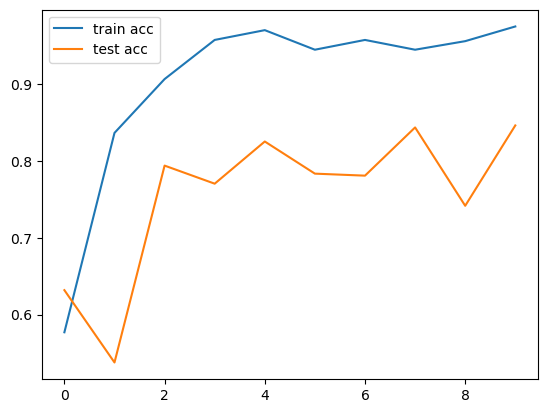

In [27]:
# Loss
import matplotlib.pyplot as plt
Epoch = 10
plt.plot(range(Epoch),train_acc_list, label="train acc")

plt.plot(range(Epoch),test_acc_list, label="test acc")
plt.legend()

In [28]:
print(train_acc_list)
print(test_acc_list)

[0.5771065182829889, 0.8362480127186009, 0.9062003179650239, 0.9570747217806042, 0.9697933227344993, 0.9443561208267091, 0.9570747217806042, 0.9443561208267091, 0.9554848966613673, 0.9745627980922098]
[0.6318537859007833, 0.5378590078328982, 0.793733681462141, 0.7702349869451697, 0.825065274151436, 0.783289817232376, 0.7806788511749347, 0.8433420365535248, 0.741514360313316, 0.8459530026109661]
